<a href="https://colab.research.google.com/github/Thayane25/Aprendizagem_de_Maquina/blob/main/Stock_SVR_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Ações Usando SVR

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# --- Ler arquivo Excel ---
price_history = pd.read_excel('stock.xlsx', index_col='Stock')

# Número de dias (colunas = datas)
daysAmount = price_history.shape[1]
print(f"{daysAmount} dias com preço de fechamento")

# Criar array de dias para usar como variável independente (X) no SVR
days = np.arange(1, daysAmount + 1).reshape(-1, 1)
print("Array de dias:\n", days)

# Transpor para colocar datas no índice e ações nas colunas
df = price_history.T

# Converter índice para datetime, tratando erros
df.index = pd.to_datetime(df.index.astype(str), errors='coerce')

# Remover linhas com datas inválidas (NaT)
n_invalid = df.index.isna().sum()
if n_invalid > 0:
    print(f"Atenção: removendo {n_invalid} linhas com datas inválidas no índice.")
    df = df[~df.index.isna()]

# Interpolar valores ausentes
stock_data = df.interpolate(method='linear')

# Dias para prever à frente
dias_futuros = 10

previsoes = {}

for stock in stock_data.columns:
    # Pegamos só os valores existentes para essa ação
    y = stock_data[stock].dropna().values
    n = len(y)

    # Criar X com índices para o SVR (de 0 a n-1)
    X = np.arange(n).reshape(-1, 1)

    # Escalar dados
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

    # Treinar SVR
    svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=1)
    svr.fit(X_scaled, y_scaled)

    # Prever para todos os dados + dias futuros
    X_pred = np.arange(n + dias_futuros).reshape(-1, 1)
    X_pred_scaled = scaler_x.transform(X_pred)

    y_pred_scaled = svr.predict(X_pred_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Datas reais
    datas_reais = stock_data.index[:n]

    # Detectar frequência das datas (para gerar datas futuras)
    freq = pd.infer_freq(stock_data.index)
    if freq is None:
        freq = 'D'  # padrão diário

    ultima_data = datas_reais[-1]
    datas_futuras = pd.date_range(start=ultima_data, periods=dias_futuros + 1, freq=freq)[1:]

    datas_pred = datas_reais.append(datas_futuras)

    previsoes[stock] = {
        "datas": datas_pred,
        "real": np.concatenate([y, [np.nan]*dias_futuros]),
        "previsto": y_pred
    }

    previstos = pd.read_excel('stock.xlsx', index_col='Stock')

    previstos[stock] = y_pred


# --- Plotar gráfico único ---

fig, ax = plt.subplots(figsize=(14, 6))

for stock, dados in previsoes.items():
    ax.plot(dados["datas"], dados["real"], label=f"{stock} - Real", linewidth=1.2)
    ax.plot(dados["datas"], dados["previsto"], linestyle='--', label=f"{stock} - SVR", linewidth=1)

step = max(len(dados["datas"]) // 10, 1)
ax.set_xticks(dados["datas"][::step])
ax.tick_params(axis='x', rotation=45)

ax.set_title("SVR - Previsão dos Preços das Ações com Extensão Futura")
ax.set_xlabel("Data")
ax.set_ylabel("Preço")
ax.legend()
ax.grid(True)

plt.subplots_adjust(bottom=0.2)
plt.show()


1322 dias com preço de fechamento
Array de dias:
 [[   1]
 [   2]
 [   3]
 ...
 [1320]
 [1321]
 [1322]]


ValueError: Length of values (1332) does not match length of index (3)

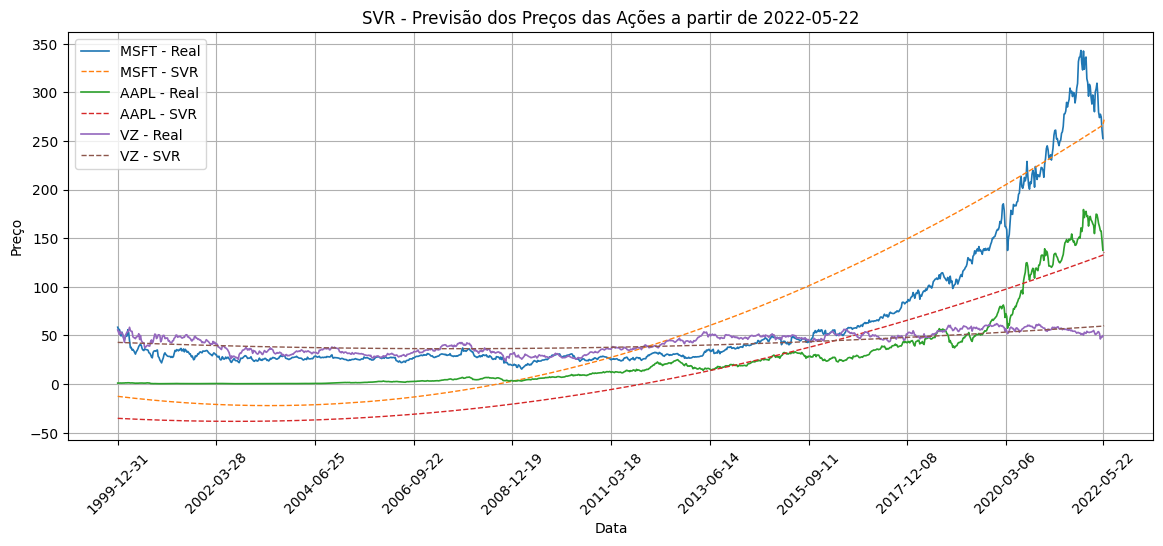

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# --- Ler arquivo Excel ---
price_history = pd.read_excel('stock.xlsx', index_col='Stock')

# Transpor para ter datas no índice e ações nas colunas
df = price_history.T

# Converter índice para datetime, tratando erros
df.index = pd.to_datetime(df.index.astype(str), errors='coerce')

# Remover linhas com datas inválidas
df = df[~df.index.isna()]

# Interpolar dados faltantes
stock_data = df.interpolate(method='linear')

# Data limite para usar os dados históricos (inclusive)
data_limite = pd.to_datetime('2022-05-22')

# Número de dias a prever após a data limite
dias_futuros = 10

previsoes = {}

for stock in stock_data.columns:
    # Filtrar dados até a data limite (inclusive)
    dados_ate_limite = stock_data.loc[:data_limite, stock].dropna()
    y = dados_ate_limite.values
    n = len(y)

    if n < 2:
        print(f"Dados insuficientes para a ação {stock} até {data_limite.date()}. Pulando.")
        continue

    # Criar variável X para o SVR (0 a n-1)
    X = np.arange(n).reshape(-1, 1)

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

    svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=1)
    svr.fit(X_scaled, y_scaled)

    # Fazer previsão para n dados + dias_futuros
    X_pred = np.arange(n + dias_futuros).reshape(-1, 1)
    X_pred_scaled = scaler_x.transform(X_pred)
    y_pred_scaled = svr.predict(X_pred_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Datas reais até a data limite
    datas_reais = stock_data.index[:n]

    # Frequência das datas para gerar datas futuras
    freq = pd.infer_freq(stock_data.index)
    if freq is None:
        freq = 'D'

    ultima_data = datas_reais[-1]
    datas_futuras = pd.date_range(start=ultima_data, periods=dias_futuros + 1, freq=freq)[1:]

    datas_pred = datas_reais.append(datas_futuras)

    previsoes[stock] = {
        "datas": datas_pred,
        "real": np.concatenate([y, [np.nan]*dias_futuros]),
        "previsto": y_pred
    }

# Plot único
fig, ax = plt.subplots(figsize=(14, 6))

for stock, dados in previsoes.items():
    ax.plot(dados["datas"], dados["real"], label=f"{stock} - Real", linewidth=1.2)
    ax.plot(dados["datas"], dados["previsto"], linestyle='--', label=f"{stock} - SVR", linewidth=1)

step = max(len(dados["datas"]) // 10, 1)
ax.set_xticks(dados["datas"][::step])
ax.tick_params(axis='x', rotation=45)

ax.set_title(f"SVR - Previsão dos Preços das Ações a partir de {data_limite.date()}")
ax.set_xlabel("Data")
ax.set_ylabel("Preço")
ax.legend()
ax.grid(True)

plt.subplots_adjust(bottom=0.2)
plt.show()


In [ ]:
print(price_history)

       1999-12-31 16:00:00  2000-01-07 16:00:00  2000-01-14 16:00:00  \
Stock                                                                  
MSFT                 58.38                55.75                56.13   
AAPL                  0.92                 0.88                 0.90   
VZ                   55.46                52.98                50.73   

       2000-01-21 16:00:00  2000-01-28 16:00:00  2000-02-04 16:00:00  \
Stock                                                                  
MSFT                 51.88                49.38                53.31   
AAPL                  0.99                 0.91                 0.96   
VZ                   54.11                51.91                52.76   

       2000-02-11 16:00:00  2000-02-18 16:00:00  2000-02-25 16:00:00  \
Stock                                                                  
MSFT                 50.25                47.50                45.78   
AAPL                  0.97                 1.00               

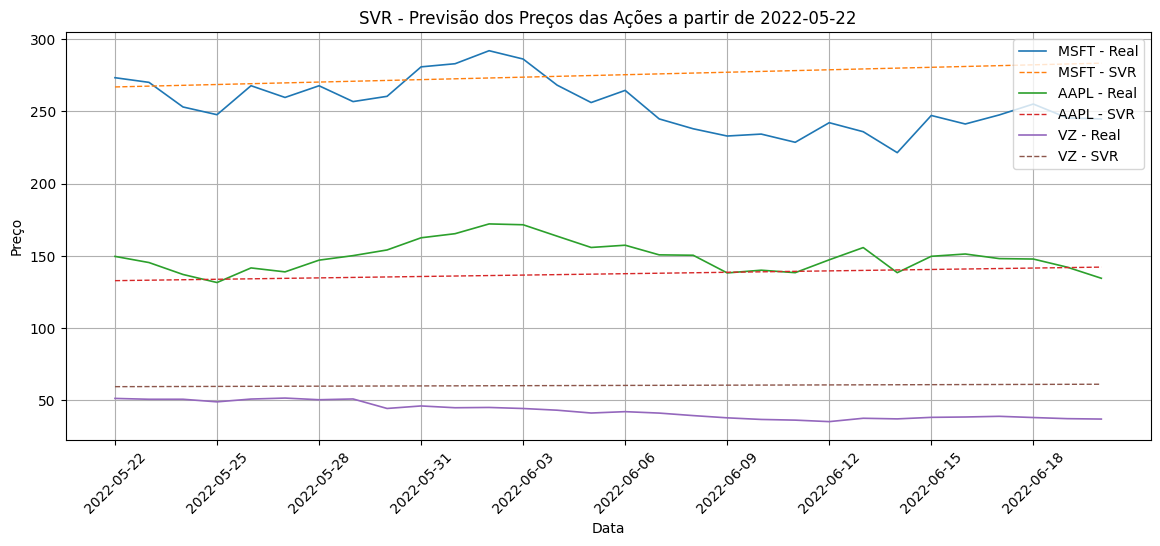

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Ler o Excel
price_history = pd.read_excel('stock.xlsx', index_col='Stock')

# Transpor para datas no índice
df = price_history.T

# Converter índice para datetime
df.index = pd.to_datetime(df.index.astype(str), errors='coerce')

# Remover datas inválidas
df = df[~df.index.isna()]

# Interpolar valores ausentes
stock_data = df.interpolate(method='linear')

# Data inicial da previsão (inclusive)
data_inicio_previsao = pd.to_datetime('2022-05-22')

# Número de dias a prever (ajuste conforme necessidade)
dias_futuros = 30

previsoes = {}

for stock in stock_data.columns:
    # Usar dados até o dia anterior a data_inicio_previsao para treinar
    dados_treino = stock_data.loc[:data_inicio_previsao - pd.Timedelta(days=1), stock].dropna()
    y_train = dados_treino.values
    n_train = len(y_train)

    if n_train < 2:
        print(f"Dados insuficientes para {stock} até {data_inicio_previsao.date() - pd.Timedelta(days=1)}. Pulando.")
        continue

    # X para treino
    X_train = np.arange(n_train).reshape(-1, 1)

    # Escalar
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    # Treinar SVR
    svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=1)
    svr.fit(X_train_scaled, y_train_scaled)

    # Criar vetor X para previsão (do primeiro dia de previsão até dias futuros)
    # Total de pontos a prever: desde 22/05/2022 até dias_futuros depois
    # Então, precisamos prever a partir do índice n_train (primeiro dia que não foi usado no treino)
    total_pred = dias_futuros  # quantos dias prever a partir da data_inicio_previsao
    X_pred = np.arange(n_train, n_train + total_pred).reshape(-1, 1)
    X_pred_scaled = scaler_x.transform(X_pred)

    y_pred_scaled = svr.predict(X_pred_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Datas reais correspondentes aos dados históricos e datas previstas
    datas_historicas = stock_data.index[:n_train]

    # Gerar datas previstas a partir de data_inicio_previsao
    freq = pd.infer_freq(stock_data.index)
    if freq is None:
        freq = 'D'
    datas_previstas = pd.date_range(start=data_inicio_previsao, periods=dias_futuros, freq=freq)

    # Concatenar datas reais e previstas para ter o índice completo da previsão
    # Mas só vamos plotar a partir de data_inicio_previsao, então:
    datas_totais = datas_previstas

    # Para plotar, pegamos os valores reais a partir de data_inicio_previsao
    dados_reais_plot = stock_data.loc[data_inicio_previsao:, stock].values
    # Ajustar tamanho para combinar com previsão (podem ter menos dias reais)
    if len(dados_reais_plot) < dias_futuros:
        # Complementar com NaNs
        dados_reais_plot = np.concatenate([dados_reais_plot, [np.nan]*(dias_futuros - len(dados_reais_plot))])
    else:
        dados_reais_plot = dados_reais_plot[:dias_futuros]

    previsoes[stock] = {
        "datas": datas_totais,
        "real": dados_reais_plot,
        "previsto": y_pred
    }

# Plot único
fig, ax = plt.subplots(figsize=(14, 6))

for stock, dados in previsoes.items():
    ax.plot(dados["datas"], dados["real"], label=f"{stock} - Real", linewidth=1.2)
    ax.plot(dados["datas"], dados["previsto"], linestyle='--', label=f"{stock} - SVR", linewidth=1)

step = max(len(dados["datas"]) // 10, 1)
ax.set_xticks(dados["datas"][::step])
ax.tick_params(axis='x', rotation=45)

ax.set_title(f"SVR - Previsão dos Preços das Ações a partir de {data_inicio_previsao.date()}")
ax.set_xlabel("Data")
ax.set_ylabel("Preço")
ax.legend()
ax.grid(True)

plt.subplots_adjust(bottom=0.2)
plt.show()


In [ ]:
import numpy as np

def cohen_d(x, y):
    """
    Calcula o d de Cohen entre dois arrays (x e y).
    d = (mean_x - mean_y) / pooled_std
    """
    x = np.array(x)
    y = np.array(y)
    # Remover pares onde qualquer um é NaN
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]

    if len(x_clean) < 2 or len(y_clean) < 2:
        return np.nan  # amostra pequena demais

    mean_x = np.mean(x_clean)
    mean_y = np.mean(y_clean)
    std_x = np.std(x_clean, ddof=1)
    std_y = np.std(y_clean, ddof=1)
    n_x = len(x_clean)
    n_y = len(y_clean)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n_x - 1)*std_x**2 + (n_y - 1)*std_y**2) / (n_x + n_y - 2))
    if pooled_std == 0:
        return 0

    d = (mean_x - mean_y) / pooled_std
    return d


# Supondo que você já tenha o dicionário `previsoes` do código anterior,
# que contém para cada ação os arrays "real" e "previsto".

cohen_results = {}

for stock, dados in previsoes.items():
    d = cohen_d(dados["real"], dados["previsto"])
    cohen_results[stock] = d

# Mostrar resultados
for stock, d_value in cohen_results.items():
    print(f"Ação: {stock} | Cohen's d: {d_value:.4f}")


Ação: MSFT | Cohen's d: -1.5445
Ação: AAPL | Cohen's d: 1.5196
Ação: VZ | Cohen's d: -4.3920


In [ ]:
import numpy as np
from scipy.stats import pearsonr

pearson_results = {}

for stock, dados in previsoes.items():
    # Remover pares com NaN
    real = np.array(dados["real"])
    previsto = np.array(dados["previsto"])
    mask = ~np.isnan(real) & ~np.isnan(previsto)
    real_clean = real[mask]
    previsto_clean = previsto[mask]

    if len(real_clean) < 2:
        corr = np.nan  # amostra pequena demais
    else:
        corr, _ = pearsonr(real_clean, previsto_clean)
    pearson_results[stock] = corr

# Mostrar resultados
for stock, corr_value in pearson_results.items():
    print(f"Ação: {stock} | Correlação de Pearson: {corr_value:.4f}")


Ação: MSFT | Correlação de Pearson: -0.5829
Ação: AAPL | Correlação de Pearson: -0.0940
Ação: VZ | Correlação de Pearson: -0.9262


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# --- Carregar dados históricos de preços semanais ---
price_history = pd.read_excel('stock.xlsx', index_col='Stock')

# Obter o número total de semanas (colunas do DataFrame)
weeks = np.array(price_history.columns).reshape(-1, 1)

# Verifica se as semanas são numéricas (ex: 1322)
weeks = weeks.astype(int)

# Última semana registrada no histórico
last_historical_week = weeks[-1][0]

# Quantidade de semanas nos últimos 5 anos (~260 semanas)
years_to_predict_in_weeks = round(365 / 7) * 5  # Aproximadamente 260

# Gerar vetor com as semanas que queremos prever (últimas 260 semanas)
future_weeks_to_predict = np.arange(
    last_historical_week - years_to_predict_in_weeks + 1,
    last_historical_week + 1
).reshape(-1, 1)

# Dicionário para armazenar previsões e valores reais
stock_predictions = {}

# --- Loop por cada ação (linha) ---
for stockTicker, stockPrices in price_history.iterrows():
    # Modelo polinomial de grau 3 (troque para LinearRegression() se quiser linear)
    model = make_pipeline(PolynomialFeatures(3), LinearRegression())

    # Treinar com todas as semanas menos as últimas 260
    model.fit(
        weeks[:-years_to_predict_in_weeks],  # Semanas antigas
        stockPrices.values[:-years_to_predict_in_weeks].reshape(-1, 1)  # Preços correspondentes
    )

    # Prever os preços nas últimas 260 semanas (sem ver esses dados antes)
    predicted_prices = model.predict(future_weeks_to_predict).flatten()
    predicted_prices = list(map(lambda p: round(p, 2), predicted_prices))  # Arredondar

    # Preços reais correspondentes às mesmas semanas (últimas 260)
    real_prices = stockPrices.values[-years_to_predict_in_weeks:]
    real_prices = list(map(lambda p: round(p, 2), real_prices))

    # Armazenar no dicionário (real e previsto)
    stock_predictions[stockTicker] = real_prices
    stock_predictions[stockTicker + 'E'] = predicted_prices

    print(f"{stockTicker} - previsão finalizada.")

# --- Salvar tudo em um CSV ---
df = pd.DataFrame(stock_predictions)
df.to_csv('forecast.csv', index=False, encoding='utf-8')

print("Arquivo 'forecast.csv' criado com previsões e preços reais.")


MSFT - previsão finalizada.
AAPL - previsão finalizada.
VZ - previsão finalizada.
Arquivo 'forecast.csv' criado com previsões e preços reais.
